In [ ]:
"""
create by: Kehan Wang
Date: 2020.6.26
"""
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
df = pd.read_csv('nyc-rolling-sales.csv')
# df.head(100)
df.head()

,Unnamed: 0,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,EASE-MENT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,,C2,153 AVENUE B,,10009,5,0,5,1633,6440,1900,2,C2,6625000,2017-07-19 00:00:00
1,5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,,C7,234 EAST 4TH STREET,,10009,28,3,31,4616,18690,1900,2,C7,-,2016-12-14 00:00:00
2,6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,,C7,197 EAST 3RD STREET,,10009,16,1,17,2212,7803,1900,2,C7,-,2016-12-09 00:00:00
3,7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,,C4,154 EAST 7TH STREET,,10009,10,0,10,2272,6794,1913,2,C4,3936272,2016-09-23 00:00:00
4,8,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,,C2,301 EAST 10TH STREET,,10009,6,0,6,2369,4615,1900,2,C2,8000000,2016-11-17 00:00:00


#1) Data Clean

First of all, we want to drop thoese useless columns and to check whether there are any duplicate values in our dataset. If there is any, we will need to drop them.

In [ ]:
# "Unname: 0" column looks like useless, drop it.
del df['Unnamed: 0']
#"EASE-MENT" column is empty, we are going to drop it.
del df['EASE-MENT']

#del df['SALE DATE']

In [ ]:
sum(df.duplicated(df.columns))
df = df.drop_duplicates(df.columns, keep='last')
df.shape

(83783, 20)

Now, Let's look into details.

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83783 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype 
---  ------                          --------------  ----- 
 0   BOROUGH                         83783 non-null  int64 
 1   NEIGHBORHOOD                    83783 non-null  object
 2   BUILDING CLASS CATEGORY         83783 non-null  object
 3   TAX CLASS AT PRESENT            83783 non-null  object
 4   BLOCK                           83783 non-null  int64 
 5   LOT                             83783 non-null  int64 
 6   BUILDING CLASS AT PRESENT       83783 non-null  object
 7   ADDRESS                         83783 non-null  object
 8   APARTMENT NUMBER                83783 non-null  object
 9   ZIP CODE                        83783 non-null  int64 
 10  RESIDENTIAL UNITS               83783 non-null  int64 
 11  COMMERCIAL UNITS                83783 non-null  int64 
 12  TOTAL UNITS                     83783 non-null

After browsing the information of dataset, we can see they use "-" to represent the missing values. Before prediction, we should clean these rows in the data table. Some of them should not be counted as the sale of real estate. For example, in column "SALE PRICE", these properties with 0 value might be transferred as a gift. 

Before cleaning missing values, We need to convert some of the columns(for example, SALE PRICE is object, SALE DATE is object, etc) to appropriate datatype.

In [ ]:
df['SALE PRICE'] = pd.to_numeric(df['SALE PRICE'], errors='coerce')
df['LAND SQUARE FEET'] = pd.to_numeric(df['LAND SQUARE FEET'], errors='coerce')
df['GROSS SQUARE FEET']= pd.to_numeric(df['GROSS SQUARE FEET'], errors='coerce')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['TAX CLASS AT PRESENT'] = df['TAX CLASS AT PRESENT'].astype('category')
df['BOROUGH'] = df['BOROUGH'].astype('category')


In [ ]:
df.shape


(83783, 20)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83783 entries, 0 to 84547
Data columns (total 20 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   BOROUGH                         83783 non-null  category
 1   NEIGHBORHOOD                    83783 non-null  object  
 2   BUILDING CLASS CATEGORY         83783 non-null  object  
 3   TAX CLASS AT PRESENT            83783 non-null  category
 4   BLOCK                           83783 non-null  int64   
 5   LOT                             83783 non-null  int64   
 6   BUILDING CLASS AT PRESENT       83783 non-null  object  
 7   ADDRESS                         83783 non-null  object  
 8   APARTMENT NUMBER                83783 non-null  object  
 9   ZIP CODE                        83783 non-null  int64   
 10  RESIDENTIAL UNITS               83783 non-null  int64   
 11  COMMERCIAL UNITS                83783 non-null  int64   
 12  TOTAL UNITS       

In [ ]:
variables = df.columns

data = []
for variable in variables:
  l = df[variable].count()
  data.append(l)
available_per = np.round(pd.Series(data)/len(df), 3)

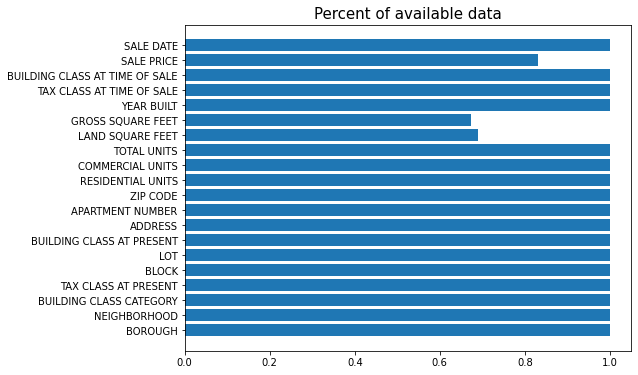

In [ ]:
plt.figure(figsize=(8,6))
plt.barh(variables, available_per)
plt.title("Percent of available data", fontsize=15)
plt.show()

As shown in the figure, SALE PRICE, GROSS SQUARE FEET and LAND SQUARE FEET have the lowest percent of available data. But again, SALE PRICE is the value we wanted to predict, and as the data set description states:

*Many sales occur with a nonsensically small dollar amount: $0 most commonly. These sales are actually transfers of deeds between parties: for example, parents transferring ownership to their home to a child after moving out for retirement.* We may want to drop those rows.

For SQUARE FEET, in this case, we will use mean values to fill them up.

In [ ]:
df=df[df['SALE PRICE']!=0]
df['LAND SQUARE FEET']=df['LAND SQUARE FEET'].fillna(df['LAND SQUARE FEET'].mean())
df['GROSS SQUARE FEET']=df['GROSS SQUARE FEET'].fillna(df['GROSS SQUARE FEET'].mean())
df.shape

(73771, 20)

In [ ]:
# Splitting dataset 
test=df[df['SALE PRICE'].isna()]
sale_house=df[~df['SALE PRICE'].isna()]

In [ ]:
test = test.drop(columns='SALE PRICE')

In [ ]:
print(test.shape)
test.head()

(14176, 19)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE DATE
1,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,26,C7,234 EAST 4TH STREET,,10009,28,3,31,4616.0,18690.0,1900,2,C7,20161214
2,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,399,39,C7,197 EAST 3RD STREET,,10009,16,1,17,2212.0,7803.0,1900,2,C7,20161209
5,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,405,16,C4,516 EAST 12TH STREET,,10009,20,0,20,2581.0,9730.0,1900,2,C4,20170720
7,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2,407,18,C7,520 EAST 14TH STREET,,10009,44,2,46,5163.0,21007.0,1900,2,C7,20170720
8,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,379,34,D5,141 AVENUE D,,10009,15,0,15,1534.0,9198.0,1920,2,D5,20170620


Now Let's recap and revisit the details of the remaining dataset.

In [ ]:
print(sale_house.shape)
sale_house.head(10)

(59595, 20)


,BOROUGH,NEIGHBORHOOD,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,BUILDING CLASS AT PRESENT,ADDRESS,APARTMENT NUMBER,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,BUILDING CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
0,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,392,6,C2,153 AVENUE B,,10009,5,0,5,1633.000000,6440.000000,1900,2,C2,6625000.0,20170719
3,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,402,21,C4,154 EAST 7TH STREET,,10009,10,0,10,2272.000000,6794.000000,1913,2,C4,3936272.0,20160923
4,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2A,404,55,C2,301 EAST 10TH STREET,,10009,6,0,6,2369.000000,4615.000000,1900,2,C2,8000000.0,20161117
6,1,ALPHABET CITY,07 RENTALS - WALKUP APARTMENTS,2B,406,32,C4,210 AVENUE B,,10009,8,0,8,1750.000000,4226.000000,1920,2,C4,3192840.0,20160923
9,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2,387,153,D9,629 EAST 5TH STREET,,10009,24,0,24,4489.000000,18523.000000,1920,2,D9,16232000.0,20161107
11,1,ALPHABET CITY,08 RENTALS - ELEVATOR APARTMENTS,2B,400,21,D1,530-532 EAST 5TH STREET,,10009,10,0,10,3717.000000,12350.000000,2009,2,D1,10350000.0,20161017
12,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,4035.581491,3891.650088,1920,2,C6,1.0,20160906
13,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,0,0,0,4035.581491,3891.650088,1920,2,C6,499000.0,20170310
14,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 3A",,10009,0,0,0,4035.581491,3891.650088,1920,2,C6,10.0,20170428
15,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3RD STREET, 5A",,10009,0,0,0,4035.581491,3891.650088,1920,2,C6,529500.0,20170609


In [ ]:
sale_house.describe()

,BLOCK,LOT,ZIP CODE,RESIDENTIAL UNITS,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,GROSS SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE
count,59595.000000,59595.000000,59595.000000,59595.000000,59595.000000,59595.000000,5.959500e+04,5.959500e+04,59595.000000,59595.000000,5.959500e+04,5.959500e+04
mean,4154.698716,390.863864,10706.268529,1.721671,0.154023,1.887927,3.812022e+03,3.597314e+03,1810.145264,1.627972,1.495862e+06,2.016728e+07
std,3569.531348,670.551351,1264.707637,14.109692,9.670540,17.212224,3.555350e+04,2.372817e+04,505.618047,0.703273,1.234024e+07,4.455825e+03
min,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000,1.000000,1.000000e+00,2.016090e+07
25%,1279.000000,21.000000,10301.000000,0.000000,0.000000,0.000000,2.000000e+03,1.300000e+03,1920.000000,1.000000,3.700000e+05,2.016120e+07
50%,3170.000000,50.000000,11207.000000,1.000000,0.000000,1.000000,3.680000e+03,2.527000e+03,1940.000000,2.000000,6.280000e+05,2.017030e+07
75%,6111.500000,1002.000000,11357.000000,2.000000,0.000000,2.000000,4.035581e+03,3.891650e+03,1966.000000,2.000000,1.075000e+06,2.017060e+07
max,16319.000000,9106.000000,11694.000000,1844.000000,2261.000000,2261.000000,4.252327e+06,3.750565e+06,2017.000000,4.000000,2.210000e+09,2.017083e+07


According to the above chart, we can observe that 

1) The min value for ZIP CODE is 0, we don't have ZIP CODE that equals to 0

2) The Building Year of some properties are 0, this should be incorrect as well.

3) Some properties have 0 SQUARE FEET...

Let's fix them

####TODO

ZIP CODE

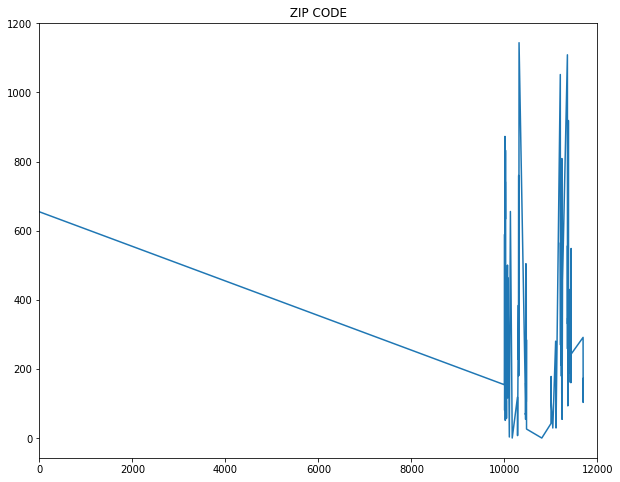

In [ ]:
plt.figure(figsize=(10,8))
plt.title(' ZIP CODE ')
plt.xlim(0,12000)

sale_house['ZIP CODE'].value_counts().sort_index().plot.line()

In [ ]:
#sale_house = sale_house[(sale_house['ZIP CODE'] != 0)]
#find the most frequent value for zipcode 
from collections import Counter
zip = Counter(sale_house['ZIP CODE'].tolist()).most_common(1)
zip

[(10314, 1144)]

In [ ]:
# so the most common zipcode is 10314
#zipcode=[]
#for i in range(len(sale_house['ZIP CODE'])):
# if sale_house['ZIP CODE'].tolist()[i] == 0:
#   zipcode.append(10314)
# else:
#   zipcode.append(sale_house['ZIP CODE'].tolist()[i])
#sale_house['ZIP CODE'] = zipcode

KeyboardInterrupt: ignored

In [ ]:
import numba as nb
@nb.jit()
def frequent(x,y):
  result=[]
  for i in range(len(x)):
    if x.tolist()[i] == 0:
      result.append(y)
    else:
      result.append(x.tolist()[i])
  return result

In [ ]:
sale_house['ZIP CODE'] = frequent(sale_house['ZIP CODE'], 10314)

<ipython-input-78-53619829ea01>:2: NumbaWarning: 
Compilation is falling back to object mode WITH looplifting enabled because Function "frequent" failed type inference due to: non-precise type pyobject
[1] During: typing of argument at <ipython-input-78-53619829ea01> (4)

File "<ipython-input-78-53619829ea01>", line 4:
def frequent(x,y):
  result=[]
  ^

  @nb.jit()
<ipython-input-78-53619829ea01>:2: NumbaWarning: 
Compilation is falling back to object mode WITHOUT looplifting enabled because Function "frequent" failed type inference due to: cannot determine Numba type of <class 'numba.dispatcher.LiftedLoop'>

File "<ipython-input-78-53619829ea01>", line 5:
def frequent(x,y):
    <source elided>
  result=[]
  for i in range(len(x)):
  ^

  @nb.jit()
/usr/local/lib/python3.6/dist-packages/numba/object_mode_passes.py:178: NumbaWarning: Function "frequent" was compiled in object mode without forceobj=True, but has lifted loops.

File "<ipython-input-78-53619829ea01>", line 4:
def frequent

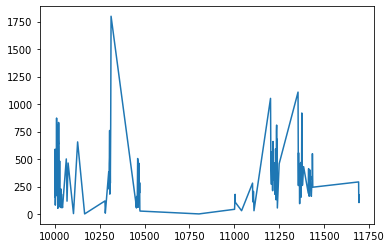

In [ ]:
sale_house['ZIP CODE'].value_counts().sort_index().plot.line()

BUILDING YEAR 

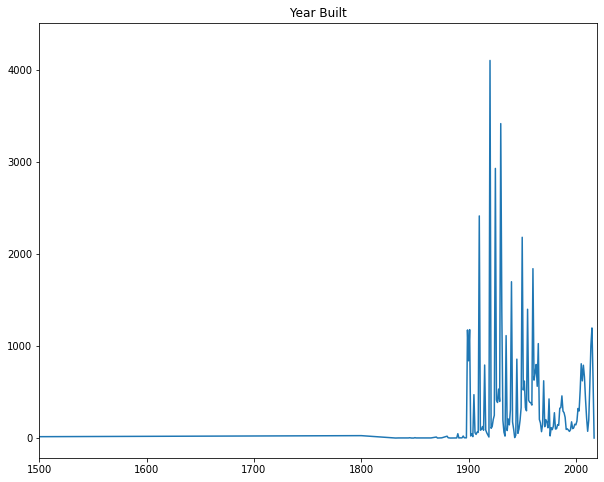

In [ ]:
plt.figure(figsize=(10,8))
plt.title(' Year Built ')
plt.xlim(1500,2020)

sale_house['YEAR BUILT'].value_counts().sort_index().plot.line()

In [ ]:
#sale_house = sale_house[(sale_house['YEAR BUILT'] > 1875)]
freyear = Counter(sale_house['YEAR BUILT'].tolist()).most_common(2)
freyear

[(0, 4296), (1920, 4103)]

In [ ]:
#yearBuilt=[]
#for i in range(len(sale_house['YEAR BUILT'])):
#    if sale_house['YEAR BUILT'].tolist()[i]==0:
#        yearBuilt.append(1920)
#    else:
#        yearBuilt.append(sale_house['YEAR BUILT'].tolist()[i])
#sale_house['YEAR BUILT']=yearBuilt


KeyboardInterrupt: ignored

In [ ]:
sale_house['YEAR BUILT'] = frequent(sale_house['YEAR BUILT'], 1920)
sale_house = sale_house[(sale_house['YEAR BUILT'] > 1875)]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


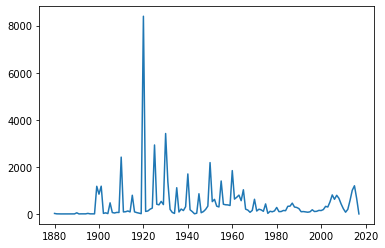

In [ ]:
sale_house['YEAR BUILT'].value_counts().sort_index().plot.line()

Finally, it's time check the outliers in our datasets, let's first look into the column sale price.

####SALE PRICE

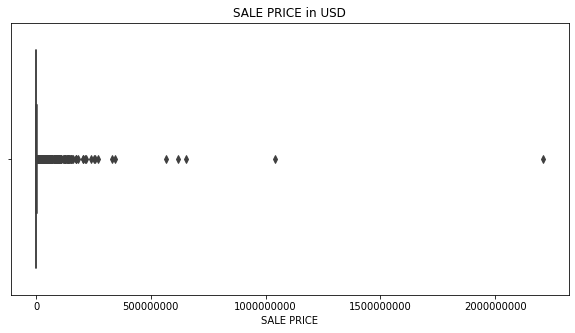

In [ ]:
plt.figure(figsize=(10,5))

sns.boxplot(x='SALE PRICE', data=sale_house)
plt.ticklabel_format(style='plain', axis='x')
plt.title('SALE PRICE in USD')
plt.show()

In [ ]:
sale_house = sale_house[(sale_house['SALE PRICE'] > 0) & (sale_house['SALE PRICE'] < 500000000)] 


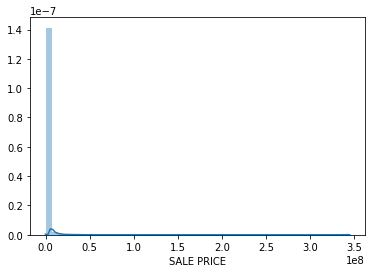

In [ ]:
sns.distplot(sale_house['SALE PRICE'])


In [ ]:
sale_house = sale_house[(sale_house['SALE PRICE'] > 0) & (sale_house['SALE PRICE'] < 5000000)]


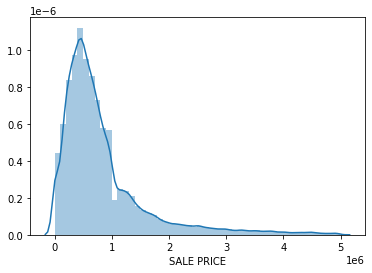

In [ ]:
sns.distplot(sale_house['SALE PRICE'])


####SQUARE FEET

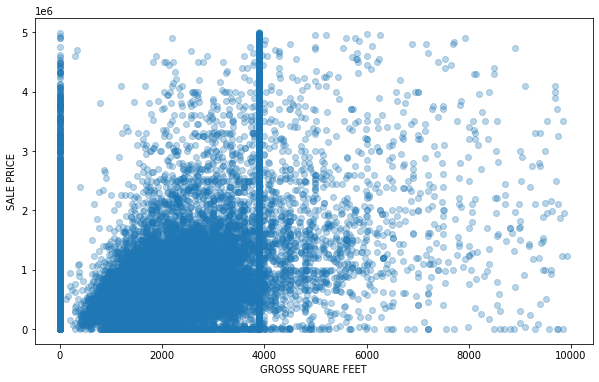

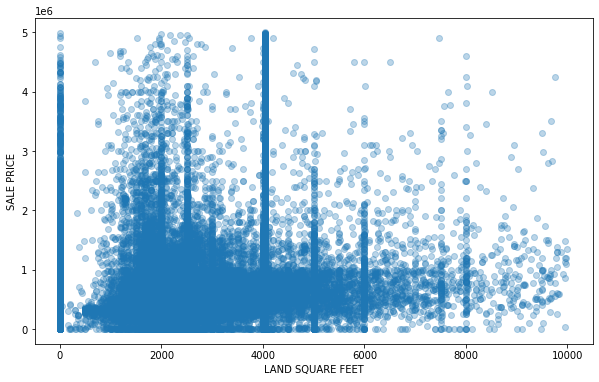

In [ ]:
sale_house = sale_house[sale_house['GROSS SQUARE FEET'] < 10000]
sale_house = sale_house[sale_house['LAND SQUARE FEET'] < 10000]

plt.figure(figsize=(10,6))
sns.regplot(x='GROSS SQUARE FEET', y='SALE PRICE', data=sale_house, fit_reg=False, scatter_kws={'alpha':0.3})

plt.figure(figsize=(10,6))
sns.regplot(x='LAND SQUARE FEET', y='SALE PRICE', data=sale_house, fit_reg=False, scatter_kws={'alpha':0.3})

####UNIT NUMBER

In [ ]:
sale_house[["TOTAL UNITS", "SALE PRICE"]].groupby(['TOTAL UNITS'], as_index=False).count().sort_values(by='SALE PRICE', ascending=False)

,TOTAL UNITS,SALE PRICE
1,1,25633
0,0,16152
2,2,9974
3,3,2892
4,4,741
6,6,377
5,5,181
8,8,143
7,7,74
9,9,58


In [ ]:
sale_house = sale_house[(sale_house['TOTAL UNITS'] > 0) & (sale_house['TOTAL UNITS'] != 2261)] 


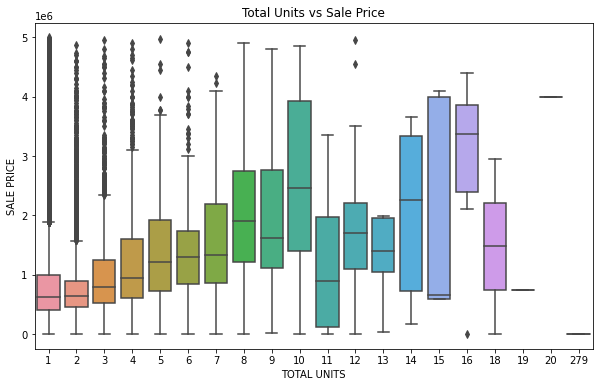

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(x='TOTAL UNITS', y='SALE PRICE', data=sale_house)
plt.title('Total Units vs Sale Price')
plt.show()

#2) Preparation

In [ ]:
#"Apartment Number" only has few values, so we are going to drop it.
print("The percent of rows with null in apartment number:" +str(sum(df['APARTMENT NUMBER']==' ')/len(df)))
del sale_house['APARTMENT NUMBER']
del sale_house['ADDRESS']

del sale_house['NEIGHBORHOOD']
del sale_house['BUILDING CLASS AT PRESENT']
del sale_house['BUILDING CLASS AT TIME OF SALE']

The percent of rows with null in apartment number:0.7702484716216399


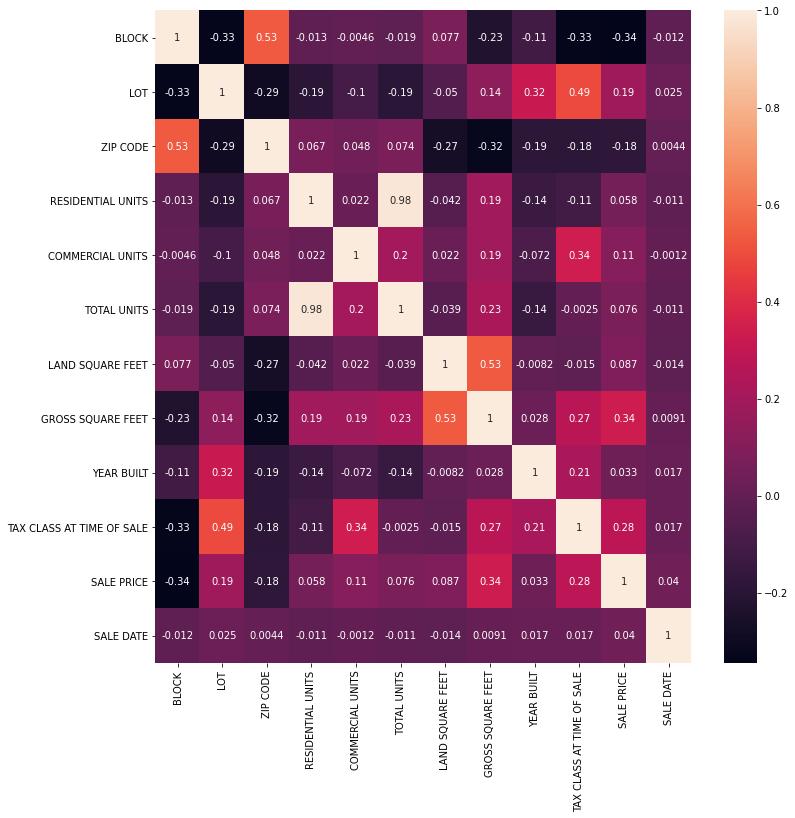

In [ ]:
cor = sale_house.corr()
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(cor,annot=True, ax = ax)

Removing highing correlated independent variable from datasets.

In [ ]:
# sale_house.drop(['RESIDENTIAL UNITS','GROSS SQUARE FEET',],inplace=True, axis=1)
# sale_house.head()

In [ ]:
combine=[]
combine = sale_house[['RESIDENTIAL UNITS','GROSS SQUARE FEET']]
combine
#sqr.append(sale_house['RESIDENTIAL UNITS'])

,RESIDENTIAL UNITS,GROSS SQUARE FEET
3,10,6794.000000
6,8,4226.000000
76,1,3891.650088
79,1,3891.650088
80,1,3891.650088
...,...,...
84537,2,2840.000000
84540,2,1300.000000
84543,2,2575.000000
84544,2,2377.000000


In [ ]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 1)
pca.fit(combine)
sale_house['COMBINE RU GSF'] = pca.transform(combine)

In [ ]:
del sale_house['RESIDENTIAL UNITS']
del sale_house['GROSS SQUARE FEET']
sale_house.head()

,BOROUGH,BUILDING CLASS CATEGORY,TAX CLASS AT PRESENT,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,COMBINE RU GSF
3,1,07 RENTALS - WALKUP APARTMENTS,2B,402,21,10009,0,10,2272.000000,1913,2,3936272.0,20160923,4568.811437
6,1,07 RENTALS - WALKUP APARTMENTS,2B,406,32,10009,0,8,1750.000000,1920,2,3192840.0,20160923,2000.811029
76,1,12 CONDOS - WALKUP APARTMENTS,2,386,1002,10009,0,1,4035.581491,1920,2,620000.0,20161230,1666.459441
79,1,13 CONDOS - ELEVATOR APARTMENTS,2,373,1003,10009,0,1,4035.581491,1920,2,762669.0,20160921,1666.459441
80,1,13 CONDOS - ELEVATOR APARTMENTS,2,373,1004,10009,0,1,4035.581491,1920,2,772851.0,20160912,1666.459441


In [ ]:
#one hot encoded
#https://machinelearningmastery.com/why-one-hot-encode-data-in-machine-learning/
one_hot_features = ['BOROUGH', 'BUILDING CLASS CATEGORY','TAX CLASS AT PRESENT','TAX CLASS AT TIME OF SALE']

In [ ]:
# Convert categorical variables into dummy/indicator variables (i.e. one-hot encoding).
one_hot_encoded = pd.get_dummies(sale_house[one_hot_features])
one_hot_encoded.info(verbose=True, memory_usage=True, null_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 40182 entries, 3 to 84545
Data columns (total 56 columns):
 #   Column                                                                Non-Null Count  Dtype
---  ------                                                                --------------  -----
 0   TAX CLASS AT TIME OF SALE                                             40182 non-null  int64
 1   BOROUGH_1                                                             40182 non-null  uint8
 2   BOROUGH_2                                                             40182 non-null  uint8
 3   BOROUGH_3                                                             40182 non-null  uint8
 4   BOROUGH_4                                                             40182 non-null  uint8
 5   BOROUGH_5                                                             40182 non-null  uint8
 6   BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS                       40182 non-null  uint8
 7   BUILDING CLAS

In [ ]:
numeric_data=sale_house.select_dtypes(include=[np.number])
numeric_data.describe()

,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,TAX CLASS AT TIME OF SALE,SALE PRICE,SALE DATE,COMBINE RU GSF
count,40182.000000,40182.000000,40182.000000,40182.000000,40182.000000,40182.000000,40182.000000,40182.000000,4.018200e+04,4.018200e+04,4.018200e+04
mean,4696.660818,469.958389,10915.795705,0.060574,1.596038,2815.495034,1951.022099,1.417376,8.765020e+05,2.016723e+07,1.215986e-11
std,3737.191029,719.199239,530.965403,0.343410,1.800708,1577.968123,37.023361,0.682293,7.706949e+05,4.465767e+03,1.410652e+03
min,1.000000,1.000000,10001.000000,0.000000,1.000000,0.000000,1880.000000,1.000000,1.000000e+00,2.016090e+07,-2.225191e+03
25%,1534.000000,28.000000,10314.000000,0.000000,1.000000,1933.000000,1920.000000,1.000000,4.300000e+05,2.016113e+07,-9.501906e+02
50%,4019.000000,62.000000,11214.000000,0.000000,1.000000,2590.000000,1940.000000,1.000000,6.516800e+05,2.017023e+07,-2.491904e+02
75%,6802.000000,1030.000000,11360.000000,0.000000,2.000000,4035.581491,1986.000000,2.000000,9.999725e+05,2.017053e+07,1.554810e+03
max,16319.000000,9106.000000,11694.000000,14.000000,279.000000,9996.000000,2017.000000,4.000000,4.996841e+06,2.017083e+07,7.700809e+03


In [ ]:
df = sale_house
scaler = StandardScaler()
scaler.fit(df[numeric_data.columns])
scaled = scaler.transform(df[numeric_data.columns])

for i, col in enumerate(numeric_data.columns):
       df[col] = scaled[:,i]

In [ ]:

df.drop(one_hot_features,axis=1,inplace=True)
df = pd.concat([df, one_hot_encoded] ,axis=1)
df.head()

,BLOCK,LOT,ZIP CODE,COMMERCIAL UNITS,TOTAL UNITS,LAND SQUARE FEET,YEAR BUILT,SALE PRICE,SALE DATE,COMBINE RU GSF,TAX CLASS AT TIME OF SALE,BOROUGH_1,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BUILDING CLASS CATEGORY_01 ONE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_02 TWO FAMILY DWELLINGS,BUILDING CLASS CATEGORY_03 THREE FAMILY DWELLINGS,BUILDING CLASS CATEGORY_04 TAX CLASS 1 CONDOS,BUILDING CLASS CATEGORY_05 TAX CLASS 1 VACANT LAND,BUILDING CLASS CATEGORY_06 TAX CLASS 1 - OTHER,BUILDING CLASS CATEGORY_07 RENTALS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_08 RENTALS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_09 COOPS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_11A CONDO-RENTALS,BUILDING CLASS CATEGORY_12 CONDOS - WALKUP APARTMENTS,BUILDING CLASS CATEGORY_13 CONDOS - ELEVATOR APARTMENTS,BUILDING CLASS CATEGORY_14 RENTALS - 4-10 UNIT,BUILDING CLASS CATEGORY_15 CONDOS - 2-10 UNIT RESIDENTIAL,BUILDING CLASS CATEGORY_16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT,BUILDING CLASS CATEGORY_21 OFFICE BUILDINGS,BUILDING CLASS CATEGORY_22 STORE BUILDINGS,BUILDING CLASS CATEGORY_23 LOFT BUILDINGS,BUILDING CLASS CATEGORY_26 OTHER HOTELS,BUILDING CLASS CATEGORY_27 FACTORIES,BUILDING CLASS CATEGORY_28 COMMERCIAL CONDOS,BUILDING CLASS CATEGORY_29 COMMERCIAL GARAGES,BUILDING CLASS CATEGORY_30 WAREHOUSES,BUILDING CLASS CATEGORY_31 COMMERCIAL VACANT LAND,BUILDING CLASS CATEGORY_32 HOSPITAL AND HEALTH FACILITIES,BUILDING CLASS CATEGORY_33 EDUCATIONAL FACILITIES,BUILDING CLASS CATEGORY_35 INDOOR PUBLIC AND CULTURAL FACILITIES,BUILDING CLASS CATEGORY_37 RELIGIOUS FACILITIES,BUILDING CLASS CATEGORY_38 ASYLUMS AND HOMES,BUILDING CLASS CATEGORY_40 SELECTED GOVERNMENTAL FACILITIES,BUILDING CLASS CATEGORY_41 TAX CLASS 4 - OTHER,BUILDING CLASS CATEGORY_42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC,BUILDING CLASS CATEGORY_43 CONDO OFFICE BUILDINGS,BUILDING CLASS CATEGORY_44 CONDO PARKING,BUILDING CLASS CATEGORY_45 CONDO HOTELS,BUILDING CLASS CATEGORY_46 CONDO STORE BUILDINGS,BUILDING CLASS CATEGORY_47 CONDO NON-BUSINESS STORAGE,BUILDING CLASS CATEGORY_48 CONDO TERRACES/GARDENS/CABANAS,BUILDING CLASS CATEGORY_49 CONDO WAREHOUSES/FACTORY/INDUS,TAX CLASS AT PRESENT_,TAX CLASS AT PRESENT_1,TAX CLASS AT PRESENT_1A,TAX CLASS AT PRESENT_1B,TAX CLASS AT PRESENT_1C,TAX CLASS AT PRESENT_2,TAX CLASS AT PRESENT_2A,TAX CLASS AT PRESENT_2B,TAX CLASS AT PRESENT_2C,TAX CLASS AT PRESENT_3,TAX CLASS AT PRESENT_4
3,-1.149182,-0.624255,-1.707846,-0.176393,4.667090,-0.344431,-1.026989,3.970194,-1.412462,3.238835,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
6,-1.148112,-0.608960,-1.707846,-0.176393,3.556402,-0.675241,-0.837917,3.005556,-1.412462,1.418377,2,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
76,-1.153464,0.739779,-1.707846,-0.176393,-0.331006,0.773211,-0.837917,-0.332823,-1.343716,1.181355,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
79,-1.156942,0.741169,-1.707846,-0.176393,-0.331006,0.773211,-0.837917,-0.147704,-1.412910,1.181355,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
80,-1.156942,0.742560,-1.707846,-0.176393,-0.331006,0.773211,-0.837917,-0.134492,-1.414925,1.181355,2,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0


In [ ]:
# classifying data into independent and dependent variable
X = df.drop(['SALE PRICE'],axis = 1).values
y = df['SALE PRICE'].values

In [ ]:
# creating test and training set data, 70% train, 30% test
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)

#3) Predition

##3.0)Helper Function

In [ ]:
def rmse(y_test,y_pred):
      return np.sqrt(mean_squared_error(y_test,y_pred))

##3.1) Linear

In [ ]:
linear=LinearRegression()
linear.fit(X_train, y_train)
y_pred = linear.predict(X_test)
result_linear = rmse(y_test, y_pred)
result_linear

0.7795214967335401

##3.2)Ridge, Lasso

In [ ]:

# fitting linear regression to training set
regressor = Ridge(alpha=0.01, normalize=True)
regressor.fit(X_train,y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=True, random_state=None, solver='auto', tol=0.001)

In [ ]:
y_pred = regressor.predict(X_test)
result_ridge = rmse(y_test, y_pred)
result_ridge

0.7793709340651975

In [ ]:
#3.6)Lasso
Lassoregressor = Lasso(alpha = 0.01, normalize =True)
Lassoregressor.fit(X_train,y_train)

y_predict = Lassoregressor.predict(X_test)
result_Lasso = rmse(y_test, y_predict)
result_Lasso

0.9864521905653756

##3.3)Random Forest

In [ ]:
from sklearn.tree import DecisionTreeRegressor
dtree = DecisionTreeRegressor()
dtree.fit(X_train, y_train)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [ ]:
y_pred = dtree.predict(X_test)
result_dt = rmse(y_test, y_pred)
result_dt

0.8022181322488974

In [ ]:
dforest = RandomForestRegressor(n_estimators=100, criterion='mse', bootstrap=True, n_jobs=-1)
dforest.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
y_pred = dforest.predict(X_test)
result_rf = rmse(y_test, y_pred)
result_rf

0.5979454452953339

##3.4)Gradient boosting

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
reg = GradientBoostingRegressor(n_estimators=100)
reg.fit(X_train, y_train)
pre = reg.predict(X_test)
result_gl = rmse(y_test, pre)
result_gl


0.6882920034436193

## 3.5)AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import GridSearchCV
reg = AdaBoostRegressor(n_estimators=100,learning_rate=0.05)
reg.fit(X_train, y_train)
pre = reg.predict(X_test)
result_ada = rmse(y_test, pre)
result_ada

0.8017812229568579

##3.6) Stacked

In [ ]:
from sklearn.linear_model import ElasticNet, Lasso,  BayesianRidge, LassoLarsIC
from sklearn.ensemble import RandomForestRegressor,  GradientBoostingRegressor
from sklearn.kernel_ridge import KernelRidge
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import lightgbm as lgb

This time we add a cross validation approach.

In [ ]:
n_folds = 5

def rmsle_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train)
    rmse= np.sqrt(-cross_val_score(model, X_train, y_train, scoring="neg_mean_squared_error", cv = kf))
    return(rmse)

In [ ]:
lasso = make_pipeline(RobustScaler(), Lasso(alpha =0.0005, random_state=1))
score = rmsle_cv(lasso)
print("\nLasso score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Lasso score: 0.7970 (0.0083)



In [ ]:
ridge = make_pipeline(RobustScaler(), Ridge(alpha =0.01, random_state=1))
score = rmsle_cv(ridge)
print("\nridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


ridge score: 0.7974 (0.0085)



In [ ]:
elastic = make_pipeline(RobustScaler(), ElasticNet(alpha =0.01, random_state=1))
score = rmsle_cv(elastic)
print("\nElastic score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


Elastic score: 0.8107 (0.0081)



In [ ]:
dforest = RandomForestRegressor(n_estimators=100, criterion='mse', bootstrap=True, n_jobs=-1)
score = rmsle_cv(dforest)
print("\nRandomF score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))


RandomF score: 0.6097 (0.0105)



In [ ]:
model_gb = GradientBoostingRegressor(n_estimators=100)
score = rmsle_cv(model_gb)
print("GB score: {:.4f} ({:.4f})\n" .format(score.mean(), score.std()))


GB score: 0.6973 (0.0046)



In [ ]:
ada = AdaBoostRegressor(n_estimators=100,learning_rate=0.05)
score = rmsle_cv(ada)
print("AdaBoost Ridge score: {:.4f} ({:.4f})\n".format(score.mean(), score.std()))

AdaBoost Ridge score: 0.8101 (0.0098)



In [ ]:
class StackingAveragedModels(BaseEstimator, RegressorMixin, TransformerMixin):
    def __init__(self, base_models, meta_model, n_folds=5):
        self.base_models = base_models
        self.meta_model = meta_model
        self.n_folds = n_folds
   
    # Fit the data on clones of the original models
    def fit(self, X, y):
        self.base_models_ = [list() for x in self.base_models]
        self.meta_model_ = clone(self.meta_model)
        kfold = KFold(n_splits=self.n_folds, shuffle=True, random_state=156)
        
        # Train cloned base models then create out-of-fold predictions
        # that are needed to train the cloned meta-model
        out_of_fold_predictions = np.zeros((X.shape[0], len(self.base_models)))
        for i, model in enumerate(self.base_models):
            for train_index, holdout_index in kfold.split(X, y):
                instance = clone(model)
                self.base_models_[i].append(instance)
                instance.fit(X[train_index], y[train_index])
                y_pred = instance.predict(X[holdout_index])
                out_of_fold_predictions[holdout_index, i] = y_pred
                
        # Now train the cloned  meta-model using the out-of-fold predictions as new feature
        self.meta_model_.fit(out_of_fold_predictions, y)
        return self
   
    #Do the predictions of all base models on the test data and use the averaged predictions as 
    #meta-features for the final prediction which is done by the meta-model
    def predict(self, X):
        meta_features = np.column_stack([
            np.column_stack([model.predict(X) for model in base_models]).mean(axis=1)
            for base_models in self.base_models_ ])
        return self.meta_model_.predict(meta_features)

In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_gb, ridge, elastic, ada, dforest),
                                                 meta_model = lasso)

score = rmsle_cv(stacked_averaged_models)
print("Stacking Averaged models score: {:.4f} ({:.4f})".format(score.mean(), score.std()))

Stacking Averaged models score: 0.6050 (0.0088)


In [ ]:
stacked_averaged_models = StackingAveragedModels(base_models = (model_gb, dforest),
                                                 meta_model = lasso)


In [ ]:
stacked_averaged_models.fit(X_train, y_train)
stacked_train_pred = stacked_averaged_models.predict(X_train)
stacked_pred = stacked_averaged_models.predict(X_test)
print(rmse(y_test, stacked_pred))

0.6045055155464264


# 3.7)Weighted Stacking

In [ ]:
from sklearn.model_selection import KFold 
X = X_train
Y = y_train
kf = KFold(n_splits=5)
pre_linear = []
pred_Lasso = []
pred_Ridge = []
pred_RF = []
pred_GBM = []
pred_Ada = []
pred_ela = []
for train_index, test_index in kf.split(X):
  linear=LinearRegression()
  linear.fit(X[train_index], Y[train_index])
  y_pred_linear = linear.predict(X[test_index])
  pre_linear = pre_linear + y_pred_linear.tolist()
  ridge = Ridge(alpha=0.01, normalize=True)
  ridge.fit(X[train_index], Y[train_index])
  y_pred_ridge = ridge.predict(X[test_index])
  pred_Ridge = pred_Ridge + y_pred_ridge.tolist()
  lasso = Lasso(alpha = 0.0005, normalize =True)
  lasso.fit(X[train_index], Y[train_index])
  y_pred_lasso = lasso.predict(X[test_index])
  pred_Lasso = pred_Lasso + y_pred_lasso.tolist()
  rf = RandomForestRegressor(n_estimators=100, criterion='mse', bootstrap=True, n_jobs=-1)
  rf.fit(X[train_index], Y[train_index])
  y_pred_rf = rf.predict(X[test_index])
  pred_RF = pred_RF + y_pred_rf.tolist()
  gbm = GradientBoostingRegressor(alpha=0.9, ccp_alpha=0.0, criterion='friedman_mse',
                          init=None, learning_rate=0.05, loss='ls', max_depth=7,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=500,
                          n_iter_no_change=None, presort='deprecated',
                          random_state=None, subsample=1.0, tol=0.0001,
                          validation_fraction=0.1, verbose=0, warm_start=False)
  gbm.fit(X[train_index], Y[train_index])
  y_pred_gbm = gbm.predict(X[test_index])
  pred_GBM = pred_GBM + y_pred_gbm.tolist()
  ada = AdaBoostRegressor(base_estimator=None, learning_rate=0.05, loss='linear',
                  n_estimators=50, random_state=None)
  ada.fit(X[train_index], Y[train_index])
  y_pred_ada = ada.predict(X[test_index])
  pred_Ada = pred_Ada + y_pred_ada.tolist()
  ela = ElasticNet(alpha =0.01, random_state=1)
  ela.fit(X[train_index], Y[train_index])
  y_pred_ela = ela.predict(X[test_index])
  pred_ela = pred_ela + y_pred_ela.tolist()

In [ ]:
combine = 0*np.array(pred_linear)+0*np.array(pred_Lasso)+0.04*np.array(pred_Ridge)+0*np.array(pred_RF)+0.96*np.array(pred_GBM)+0*np.array(pred_Ada)
rmse(combine,y_train)

0.604948553928992

In [ ]:
from scipy.optimize import nnls 
fin_mat = np.zeros((26231,6))
fin_mat[:,0]=np.array(pre_linear)
fin_mat[:,1]=np.array(pred_Lasso)
fin_mat[:,2]=np.array(pred_Ridge)
fin_mat[:,3]=np.array(pred_RF)
fin_mat[:,4]=np.array(pred_GBM)
fin_mat[:,5]=np.array(pred_Ada)
fin_mat
b=nnls(fin_mat, y_train)
b

(array([4.86855450e-02, 0.00000000e+00, 0.00000000e+00, 4.37822289e-01,
        5.21608000e-01, 2.42489302e-04]), 96.49097410572348)